In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
from importlib import reload

In [2]:
sys.path.append("../../src")
import main
import vis

In [3]:
reload(vis)

<module 'vis' from '/Users/lisawink/Documents/morphomet/notebooks/visualisations/../../src/vis.py'>

In [7]:
temp = pd.read_csv('../../data/raw_data/ta_vp_rh_60_min_2022_09_01_2024_08_31_gap_filled_new.csv')
temp['datetime']=pd.to_datetime(temp['datetime'])
temp['datetime_UTC'] = temp['datetime']
temp['value'] = temp['ta']
temp = temp[temp['type'] == 'measured']

In [8]:
temp = temp[temp['station_id'] != 'FREICH']
temp = temp[temp['station_id'] != 'FRWITT']

In [9]:
temp

,datetime,station_id,ta,vp,type,svp,rh,rh_corr,vp_corr,datetime_UTC,value
1,2022-09-01 00:00:00+00:00,FRBETZ,16.713000,1.459968,measured,1.902704,76.731260,76.731260,1.459968,2022-09-01 00:00:00+00:00,16.713000
2,2022-09-01 00:00:00+00:00,FRBRUH,16.285000,1.484469,measured,1.851591,80.172596,80.172596,1.484469,2022-09-01 00:00:00+00:00,16.285000
3,2022-09-01 00:00:00+00:00,FRDIET,13.840833,1.580545,measured,1.582116,99.900751,99.900751,1.580545,2022-09-01 00:00:00+00:00,13.840833
4,2022-09-01 00:00:00+00:00,FRDREI,16.611667,1.495245,measured,1.890492,79.092899,79.092899,1.495245,2022-09-01 00:00:00+00:00,16.611667
7,2022-09-01 00:00:00+00:00,FRFRIE,15.087667,1.575205,measured,1.714939,91.851936,91.851936,1.575205,2022-09-01 00:00:00+00:00,15.087667
...,...,...,...,...,...,...,...,...,...,...,...
736842,2024-08-31 23:00:00+00:00,FRWAHS,19.772667,2.303292,measured,2.305502,99.904139,99.904139,2.303292,2024-08-31 23:00:00+00:00,19.772667
736843,2024-08-31 23:00:00+00:00,FRWEIN,21.971333,2.034244,measured,2.639229,77.077218,77.077218,2.034244,2024-08-31 23:00:00+00:00,21.971333
736844,2024-08-31 23:00:00+00:00,FRWILD,20.055333,2.334988,measured,2.346226,99.521040,99.521040,2.334988,2024-08-31 23:00:00+00:00,20.055333
736846,2024-08-31 23:00:00+00:00,FRWSEE,20.621167,2.011211,measured,2.429639,82.778178,82.778178,2.011211,2024-08-31 23:00:00+00:00,20.621167


In [10]:
stations = pd.read_csv("../../data/raw_data/Freiburg-Street-Level-Weather-Station-Network-MetaData-V1-0.csv")

In [11]:
temp['month'] = temp['datetime_UTC'].dt.month

# Temperature Minimum and Maximum

In [12]:
temp.idxmin()

datetime             1
station_id       13020
ta              109121
vp              109196
type                 1
svp             109121
rh              287913
rh_corr         287913
vp_corr         109196
datetime_UTC         1
value           109121
month           122976
dtype: int64

In [13]:
temp.loc[109196]

datetime        2022-12-18 07:00:00+00:00
station_id                         FRWILD
ta                                -12.008
vp                               0.218683
type                             measured
svp                              0.243289
rh                              89.886106
rh_corr                         89.886106
vp_corr                          0.218683
datetime_UTC    2022-12-18 07:00:00+00:00
value                             -12.008
month                                  12
Name: 109196, dtype: object

In [47]:
jan = temp[temp['month'] == 1]
dec = temp[temp['month'] == 12]
feb = temp[temp['month'] == 2]

In [49]:
jan['value'].mean(), dec['value'].mean(), feb['value'].mean()

(4.440874253454469, 5.27774911086082, 6.854558385369773)

In [51]:
jul = temp[temp['month'] == 7]
aug = temp[temp['month'] == 8]
sep = temp[temp['month'] == 9]

jul['value'].mean(), aug['value'].mean(), sep['value'].mean()

(21.678580402718197, 21.863760114255932, 18.025949275616952)

In [14]:
mean = temp['value'].mean()

In [15]:
mean

13.284654178860306

In [16]:
std = temp['value'].std()

In [17]:
std

7.982263291445027

# Diurnal Amplitude

In [52]:
# for each day, do max - min
temp['day'] = temp['datetime_UTC'].dt.date
temp['day'] = pd.to_datetime(temp['day'])
daily = temp.groupby(['day', 'station_id']).agg({'value': ['max', 'min']})
daily.columns = ['max', 'min']
daily = daily.reset_index()
daily['range'] = daily['max'] - daily['min']

In [54]:
# drop 2024-09-01
daily = daily[daily['day'] != '2024-09-01']

In [57]:
daily['range'].mean()

8.875418531099315

In [60]:
daily[daily['station_id'] == 'FRKART']['range'].mean()


7.176554615544459

In [61]:
daily[daily['station_id'] == 'FRHOCH']['range'].mean()

9.932335126250342

# Temperature Plots

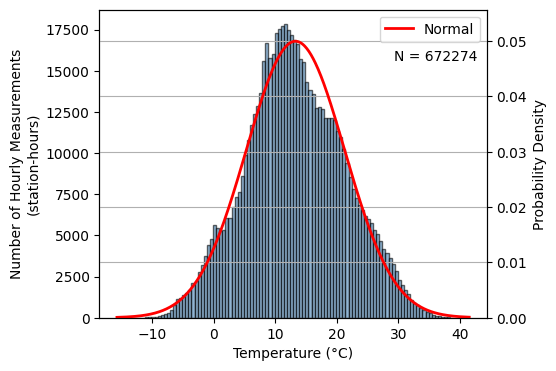

In [29]:
fig, ax = plt.subplots(figsize=(5, 4))
ax2 = ax.twinx()
# Histogram
binwidth =0.5
data = temp['value']
ax.hist(temp['value'], bins=np.arange(min(data), max(data) + binwidth, binwidth), density=False, alpha=0.6, color='steelblue', edgecolor='black')
ax2.hist(temp['value'], bins=np.arange(min(data), max(data) + binwidth, binwidth), density=True, alpha=0.0, color='steelblue', edgecolor='black')

# Overlay normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p = norm.pdf(x, mean, std)
ax2.plot(x, p, 'r', linewidth=2, label='Normal')

#put N in plot
n = len(temp['value'])
ax.text(0.76, 0.87, f'N = {n}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.set_xlabel("Temperature (°C)")
ax.set_ylabel("Number of Hourly Measurements\n(station-hours)")
ax2.set_ylabel("Probability Density")
plt.legend()
plt.grid()
plt.savefig('../../figures/fig4/temp_dist_nov.png',bbox_inches='tight', dpi=300)
plt.savefig('../../figures/fig4/temp_dist_nov.svg',bbox_inches='tight')
plt.savefig('../../figures/fig4/temp_dist_nov.pdf',bbox_inches='tight')
plt.show()

In [17]:
stats.normaltest(temp['value'])

NormaltestResult(statistic=4847.748316920086, pvalue=0.0)

In [18]:
temp['value'].skew()

0.0872414387659946

# CL-UHI Magnitude

In [20]:
var = 'BuAre_sum'

In [21]:
stats_dict = pd.read_csv(f'../../data/processed_data/calplot_data/{var}_300_fraction_of_night.csv')

In [22]:
uhi_n = stats_dict[(stats_dict['fraction_of_night'] < 1) & (stats_dict['fraction_of_night'] > 0)]['UHI Magnitude']

In [23]:
uhi_n

0        3.152958
1        2.941792
2        3.213167
3        2.769500
4        1.996708
           ...   
17540    2.704750
17541    2.706542
17542    2.816708
17543    3.804958
17544    3.681917
Name: UHI Magnitude, Length: 8606, dtype: float64

In [24]:
mean_uhi = uhi_n.mean()
std_uhi = uhi_n.std()

In [25]:
np.median(uhi_n), np.percentile(uhi_n, 90)

(1.5230896084999996, 3.856405636625001)

In [26]:
uhi_n

0        3.152958
1        2.941792
2        3.213167
3        2.769500
4        1.996708
           ...   
17540    2.704750
17541    2.706542
17542    2.816708
17543    3.804958
17544    3.681917
Name: UHI Magnitude, Length: 8606, dtype: float64

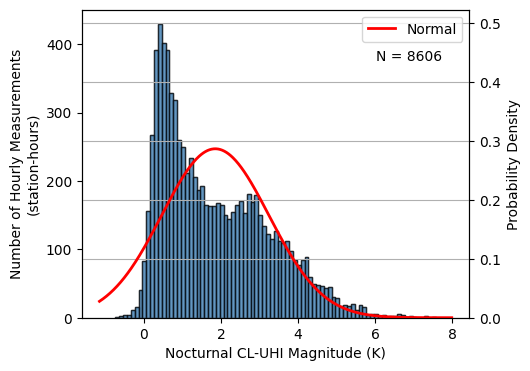

In [30]:
fig, ax = plt.subplots(figsize=(5, 4))
ax2 = ax.twinx()
data= uhi_n
binwidth = 0.1
ax.hist(uhi_n, bins=np.arange(min(data), max(data) + binwidth, binwidth), density=False, alpha=0.6, color='steelblue', edgecolor='black')
ax2.hist(uhi_n, bins=np.arange(min(data), max(data) + binwidth, binwidth), density=True, alpha=0.6, color='steelblue', edgecolor='black')
# Histogram

# Overlay normal distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 500)
p = norm.pdf(x, mean_uhi, std_uhi)
plt.plot(x, p, 'r', linewidth=2, label='Normal')

n = len(uhi_n)
ax.text(0.76, 0.87, f'N = {n}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.set_xlabel("Nocturnal CL-UHI Magnitude (K)")
ax.set_ylabel("Number of Hourly Measurements\n(station-hours)")
ax2.set_ylabel("Probability Density")

plt.legend()
plt.grid(True)
plt.savefig('../../figures/fig4/uhi_dist_new.png',bbox_inches='tight')
plt.savefig('../../figures/fig4/uhi_dist_new.svg',bbox_inches='tight')
plt.savefig('../../figures/fig4/uhi_dist_new.pdf',bbox_inches='tight')
plt.show()